<h1><b>Méthode : Ensemble Kalman Filter (EnKF)</b></h1>

Ce notebook présente l'utilisation du fichier `kalmanWoFost.py` pour assimiler des données

In [5]:
import sys
sys.path.insert(0, '..\SOURCE')
sys.path.insert(0, '..\data')
from kalmanWoFost import KalmanWofostDA
import numpy as np 
from pcse.models import Wofost72_WLP_FD
import datetime as dt
import pandas as pd

from dataloader import Dataloader
import os

from pcse.base import ParameterProvider
from utils import *

## 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.
Dans cet exemple, on va essayer de simuler le champ de notre client


In [9]:
dataloader = Dataloader("data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**
soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


In [10]:

cropd = dataloader.getCropData('potato', 'Innovator')
print(cropd)

YAMLCropDataProvider - current active crop 'potato' with variety 'Innovator'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 3.0, 'TEFFMX': 18.0, 'TSUMEM': 255, 'IDSL': 0, 'DLO': -99.0, 'DLC': -99.0, 'TSUM1': 187, 'TSUM2': 2100, 'DTSMTB': [0.0, 0.0, 2.0, 0.0, 13.0, 11.0, 30.0, 28.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 14.0, 'VERNSAT': 70.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 75.0, 'RGRLAI': 0.017, 'SLATB': [0.0, 0.0017, 1.0, 0.0024, 2.0, 0.0024], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 35.0, 'TBASE': 2.0, 'KDIFTB': [0.0, 1.0, 2.0, 1.0], 'EFFTB': [0.0, 0.49, 40.0, 0.49], 'AMAXTB': [0.0, 33.0, 2.0, 33.0], 'REFCO2L': 400, 'TMPFTB': [0.0, 0.01, 3.0, 0.01, 10.0, 0.75, 15.0, 1.0, 24.0, 1.0, 29.

## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [11]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail()
#plotWofostDF(df_wofost_noDA)

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.210785,22.854223
2022-10-03,1.989233,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.233511,23.990529
2022-10-04,1.993524,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.231742,23.902066
2022-10-05,1.998490,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.230323,23.831142
2022-10-06,2.000000,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.229986,23.814270


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client. On va commencer par tracer deux graphes: l'un pour <b>comprarer les différentes courbes d'humidité et la simulation WOFOST</b>, l'autre avec l'humidité retenu et la prédiction du modèle WOFOST.

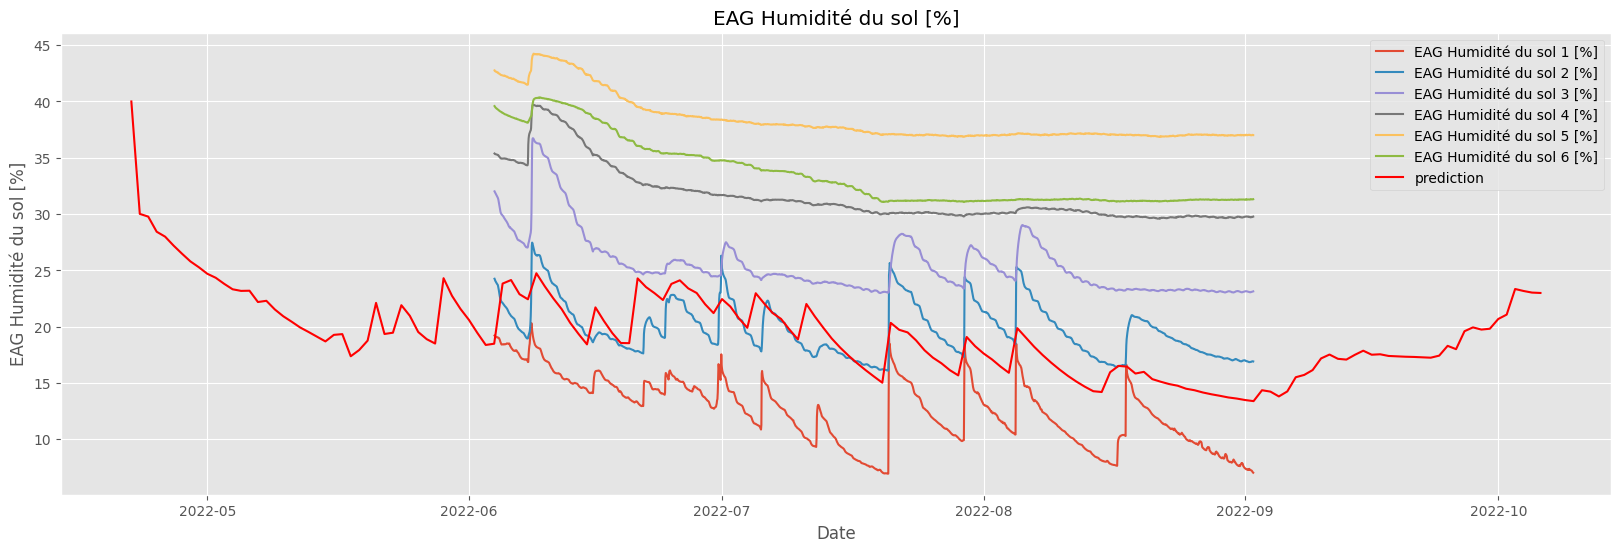

In [12]:
import matplotlib.pyplot as plt

df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction', color="r")

plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

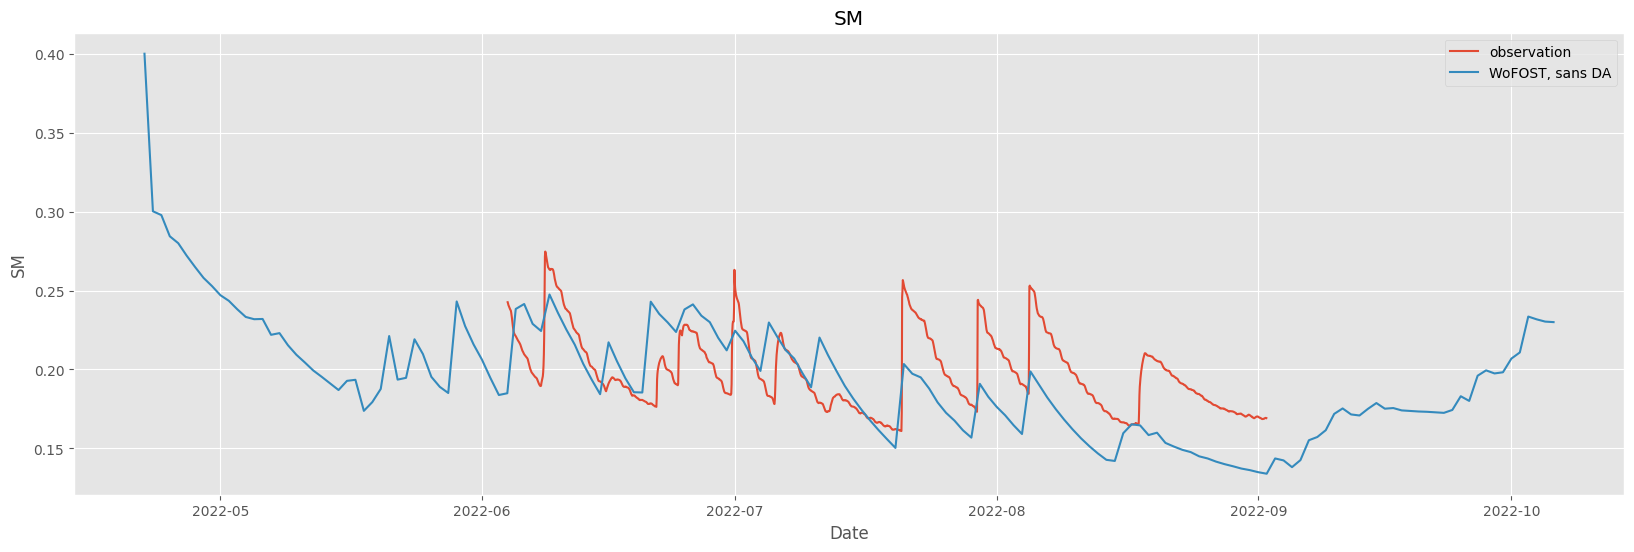

In [13]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition. Il suffira de changer ```NB_DAYS_DELTA``` pour obtenir un autre échantillonage.

In [14]:
NB_DAYS_DELTA = 4
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

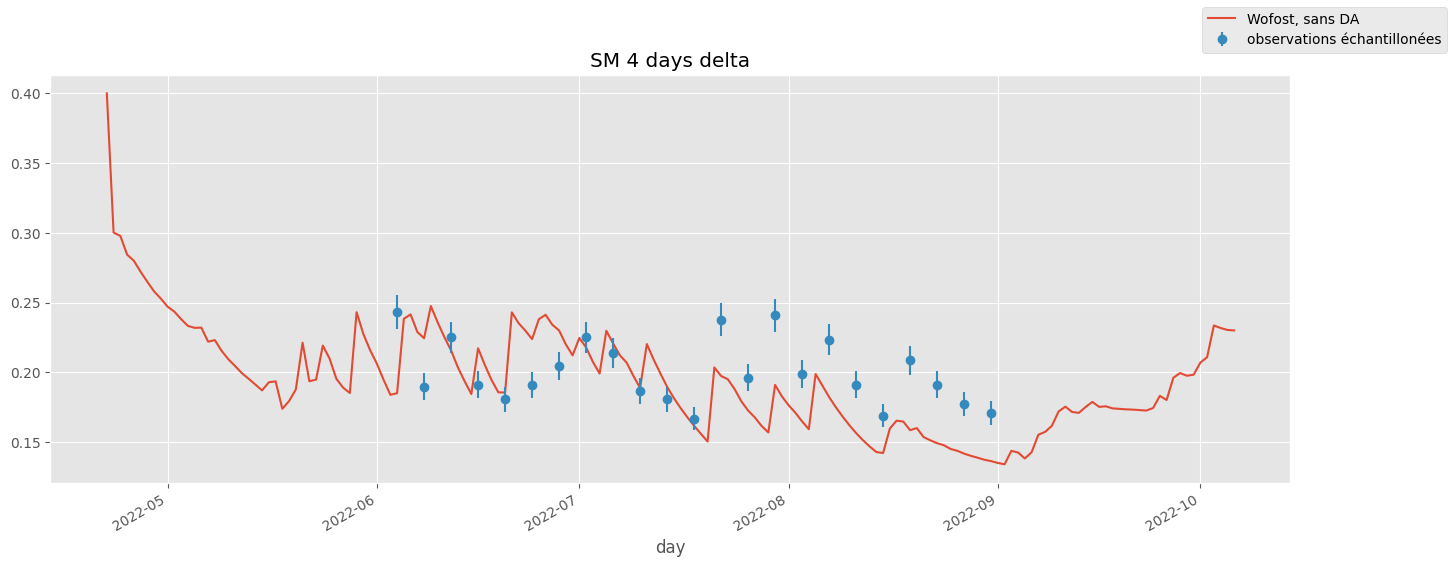

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA")
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

On doit maintenant tout rassembler sous le format permettant d'entraîner le modèle. On utilise une liste de tuple liant la date aux informations de l'humidité du sol.

Le choix de ce format permet d'inclured d'autres types d'informations: ici, on a mis uniquement ```SM```, mais on pourrait rajouter ```LAI```.

In [16]:
observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]

## 4 - EnKF

On peut maintenant utiliser l'EnKF

Il faut d'abord spécifier les paramètres sur lesquels on a un doute pour que le modèle sache qu'il doit itérer ceux ci.

In [17]:
ensemble_size = 50
np.random.seed(10000)

print("TDWI", parameters['TDWI'])
print("WAV", parameters["WAV"])
print("SPAN", parameters["SPAN"])
print("SMFCF", parameters["SMFCF"])

TDWI 75.0
WAV 10.0
SPAN 35.0
SMFCF 0.3



On créé ensuite une zone de recherche autour des paramètres que l'on cherche à assimiler.

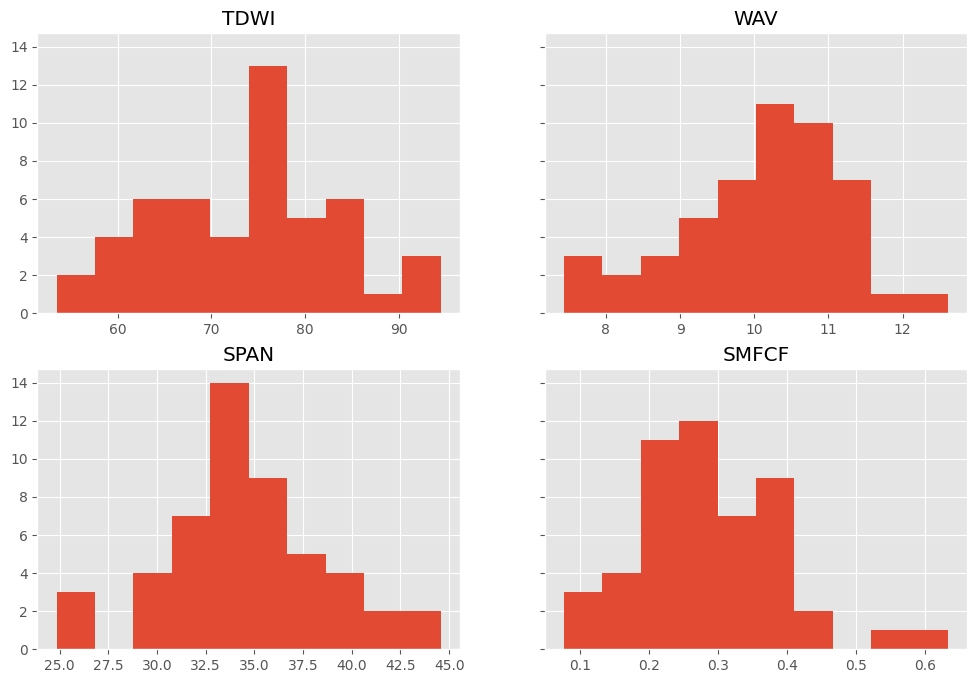

In [18]:
ensemble_size = 50

override_parameters = {}
# Conditions Initiales
override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
# Paramètres
override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
override_parameters["SMFCF"] = np.maximum(0.01, np.random.normal(parameters['SMFCF'], 0.1 ,(ensemble_size)))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Tracer les histogrammes des paramètres
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

Finalement, on peut créer et faire tourner notre modèle. On a importé initialement le module ```KalmanWofostDA``` qui permet l'apprentissage. On lui donne en argument les paramètres préparé précédemment ainsi que la liste des paramètres à essayer (```override_parameters```).

In [19]:
kwf = KalmanWofostDA(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
kwf.batchAssimilate(observations_for_DA)
df_enkf_DA = kwf.getResultsWithDA()
df_enkf_NODA = kwf.getResultsNoDA()

[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.18969999999999998, 0.009485)} on day 2022-06-08 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1911, 0.009555000000000001)} on day 2022-06-16 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.22510000000000002, 0.011255000000000001)} on day 2022-07-02 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2139, 0.010695000000000001)} on day 2022-07-06 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM'

In [20]:
# Afficher les résultats de l'assimilation
df_enkf_DA.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-08-27,1.738300,0.282392,15140.753857,12103.231746,1585.360986,1452.161125,1239.132361,0.053902,50.0,0.172646,21.153783
2022-08-28,1.746295,0.242934,15152.833013,12115.247679,1585.360986,1452.224347,1239.132361,0.050190,50.0,0.173386,21.190786
2022-08-29,1.754505,0.215088,15161.503512,12123.874183,1585.360986,1452.268342,1239.132361,0.050509,50.0,0.169715,21.007224
2022-08-30,1.763114,0.185857,15167.668212,12130.008615,1585.360986,1452.298610,1239.132361,0.038880,50.0,0.166470,20.844974
2022-08-31,1.771819,0.160627,15172.743605,12135.059962,1585.360986,1452.322656,1239.132361,0.032520,50.0,0.164086,20.725809


On va pouvoir tracer les courbes d'intérêt du modèle. En particulier, il faut que l'on compare avant/après l'assimilation de données, et que l'on s'intéresse au rendement des champs.

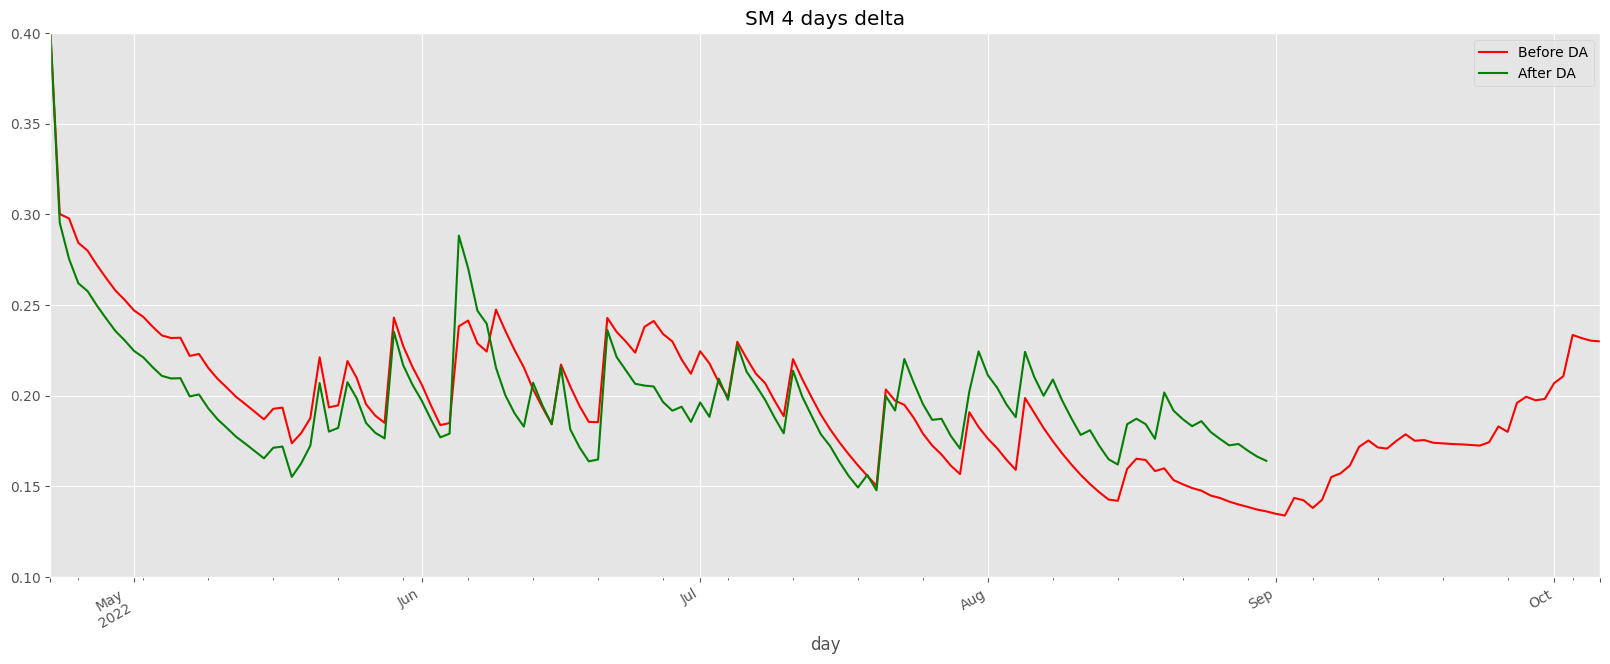

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

# axes.plot(df_obs['Date/heure'], df_obs["SM"], label="All Observations", color='b')

df_enkf_NODA['SM'].plot(ax=axes, label="Before DA", color='r')
df_enkf_DA['SM'].plot(ax=axes, label="After DA", color='g')

# axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='RED', label='Observations (sampled)')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
axes.set_ylim([0.1, 0.4])

axes.legend()

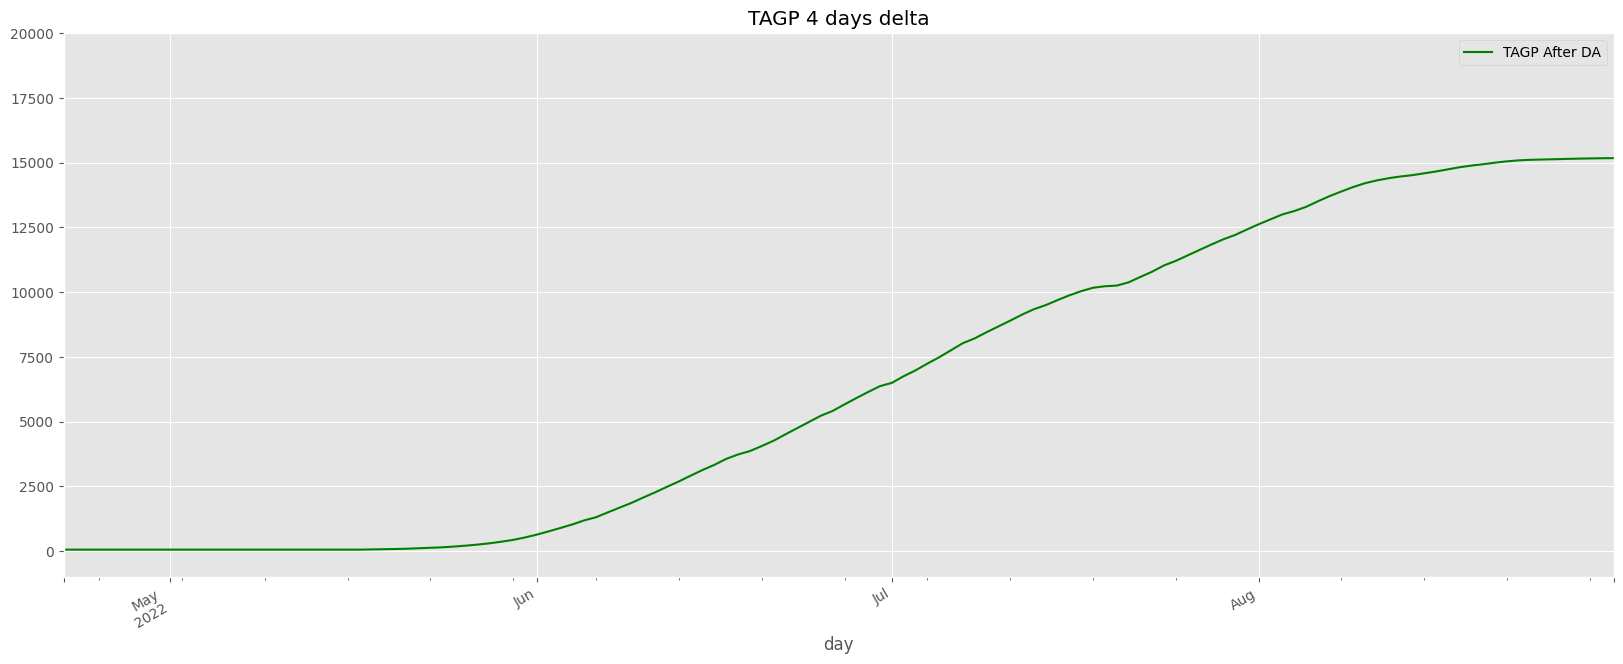

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

df_enkf_DA['TAGP'].plot(ax=axes, label="TAGP After DA", color='g')

#axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='gray')
axes.set_title("TAGP "+str(NB_DAYS_DELTA)+" days delta")
axes.set_ylim([-1000, 20000])
fig.autofmt_xdate()

axes.legend()

In [29]:
df_obs_undersample = df_obs[df_obs['Date/heure'].dt.hour == 0]
df_obs_undersample.set_index('Date/heure', inplace=True)
minDay = max((df_obs_undersample.index.min()), df_enkf_DA.index.min())
maxDay = min(df_obs_undersample.index.max(), df_enkf_DA.index.max())

print('Days for RMSE:',minDay, maxDay)
SM_obs = df_obs_undersample.loc[(df_obs_undersample.index >= minDay) & (df_obs_undersample.index <= maxDay), 'SM'].to_numpy()
SM_DA = df_enkf_DA.loc[(df_enkf_DA.index >= minDay) & (df_enkf_DA.index <= maxDay), 'SM'].to_numpy()
SM_noDA = df_enkf_NODA.loc[minDay:maxDay, 'SM'].to_numpy()

print('RMSE with DA with ENKF: {}'.format(np.sqrt(np.mean((SM_obs-SM_DA)**2))))
print('RMSE without DA : {}'.format(np.sqrt(np.mean((SM_obs-SM_noDA)**2))))


Days for RMSE: 2022-06-05 00:00:00 2022-08-31 00:00:00
RMSE with DA with ENKF: 0.023980012057811414
RMSE without DA : 0.029704614873724913


Témoin (RMSE en % de la moyenne des SM): 0.14934446894783768


c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


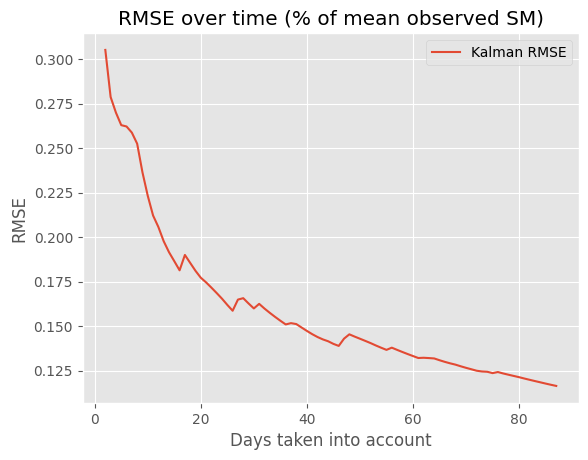

In [31]:
rsme = {i:np.sqrt(np.mean((SM_obs[1:i]-SM_DA[1:i])**2)) for i in range(len(SM_DA))}
plt.plot(list(rsme.keys()),list(rsme.values())/np.mean(SM_obs), label="Kalman RMSE")
print("Témoin (RMSE en % de la moyenne des SM): {}".format(np.sqrt(np.mean((SM_obs-SM_noDA)**2))/np.mean(SM_obs)))
plt.title("RMSE over time (% of mean observed SM)")
plt.xlabel("Days taken into account")
plt.ylabel("RMSE")
plt.legend()

On peut tirer plusieurs conclusion de ce dernier graphique. Le RMSE est initalement plutôt petit: le KF est assez efficace. Après plusieurs itérations, il se stagne vers 0.11 d'écart, ce qui correspond à 11% d'écarts sur la période.
    <style>
        table {
            width: 100%;
        }
    </style>
| Pas des jours | Erreur RMSE (%) |
|---------------|-------|
|1|8,5|
| 2             | 10,5  |
| 4             | 11,7  |
| 8             | 11,8  |
| 10            | 12,8  | 
| <i>témoin</i>        | <i>14,9</i>  |
